In [1]:
from __future__ import annotations

from collections.abc import Iterable
from itertools import pairwise, chain
from typing import Callable, Any

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision
import tqdm.auto as tqdm
from torch import nn
import math
from torch.distributions.multivariate_normal import MultivariateNormal
from numba import cuda

%env KERAS_BACKEND=torch

import keras
from keras import layers
import keras_tuner

env: KERAS_BACKEND=torch


In [2]:
# Move to project root
from pathlib import Path
import os

if not Path("./checkpoints").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "checkpoints").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./checkpoints").is_dir()

In [3]:
from src import convolutions

In [4]:
plt.set_cmap("Blues");

<Figure size 640x480 with 0 Axes>

In [5]:
test_data = torch.zeros(2, 4, 10, 10, device="cuda")
test_data[:, 0, 3, :] = 1.0
test_data[:, 1, :, 3] = 2.0
test_data[:, 2, 7, :] = 2.0
test_data[:, 3, :, 7] = 1.0
test_data[1] *= 3

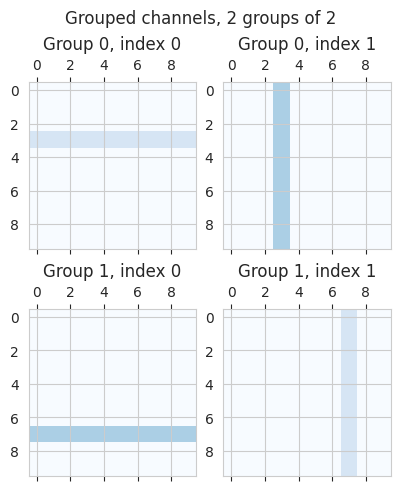

In [6]:
def plot_grouped_data(
    data: torch.Tensor,
    groups: int,
    is_kernel: bool = False,
    vmin: int = 0,
    vmax: int = 6,
):
    data = data.numpy(force=True).clip(-100, 100)
    if len(data.shape) == 4:
        data = data[0]
    assert len(data.shape) == 3
    assert data.shape[0] % groups == 0, (
        f"{data.shape[0]=} % {groups=} = {data.shape[0] % groups}"
    )
    alt = data.shape[0] // groups
    if is_kernel:
        group_size, groups = groups, alt
    else:
        group_size, groups = alt, groups

    fig, axss = plt.subplots(groups, group_size, layout="compressed")
    if groups == 1:
        axss = axss.reshape(1, -1)
    elif len(axss.shape) == 1:
        axss = axss.reshape(-1, 1)

    axss: list[list[plt.Axes]]

    for grp, axs in enumerate(axss):
        for grp_idx, ax in enumerate(axs):
            ax.matshow(data[grp * group_size + grp_idx], vmin=vmin, vmax=vmax)
            if not is_kernel:
                ax.set_title(f"Group {grp}, index {grp_idx}")
            else:
                ax.set_title(f"G {grp // group_size}, i {grp_idx}")

    fig.suptitle(f"Grouped channels, {groups} groups of {group_size}")
    fig.show(warn=False)


plot_grouped_data(test_data, groups=2)

In [7]:
INF = float("inf")
knl_id = [[INF, INF, INF], [INF, 0, INF], [INF, INF, INF]]
knl_vert = [[INF, 0, INF], [INF, 0, INF], [INF, 0, INF]]
knl_hori = [[INF, INF, INF], [0, 0, 0], [INF, INF, INF]]
knl_full = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

test_kernels = -torch.asarray(
    [
        [knl_hori, knl_vert],
        [knl_vert, knl_hori],
        [knl_full, knl_id],
        [knl_id, knl_full],
    ],
    device="cuda",
)
test_kernels.shape

torch.Size([4, 2, 3, 3])

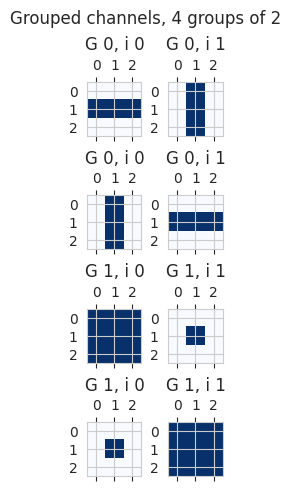

In [8]:
plot_grouped_data(test_kernels.view(8, 3, 3), groups=2, is_kernel=True, vmin=-1, vmax=0)

In [9]:
import importlib
from src.convolutions import cuda_select, utils

importlib.reload(cuda_select)
importlib.reload(utils)
importlib.reload(convolutions)
from src import convolutions

In [12]:
ss_op = torch.compile(
    convolutions.SelectSemifield.tropical_max().module(2), backend="inductor"
)
ss_op

OptimizedModule(
  (_orig_mod): SelectConv()
)

Inferred meta=ConvMeta(img_bs=2, img_cs=4, img_ys=10, img_xs=10, krn_o_group_size=2, krn_os=4, krn_cs=2, krn_ys=3, krn_xs=3, out_cs=4, out_ys=10, out_xs=10, stride=1, padding=1, dilation=1, groups=2, group_broadcasting=False)
torch.Size([2, 4, 10, 10]) tensor(0., device='cuda:0') tensor(6., device='cuda:0')


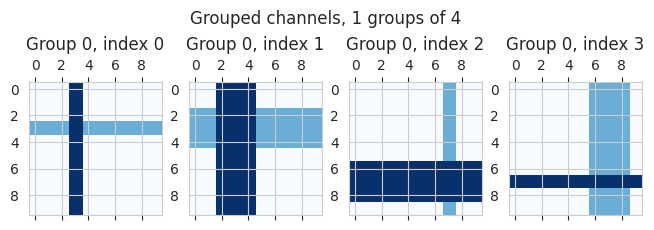

In [13]:
res_ss = ss_op(test_data, test_kernels, groups=2, debug=True, padding=1)
print(res_ss.shape, res_ss.min(), res_ss.max())
plot_grouped_data(res_ss[1], 1)

torch.Size([2, 4, 10, 10])


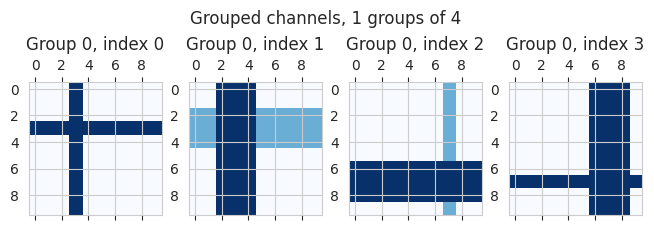

In [14]:
res_lin = nn.functional.conv2d(
    test_data, (test_kernels == 0).float(), groups=2, padding=1
)
print(res_lin.shape)
plot_grouped_data(res_lin[1], 1)

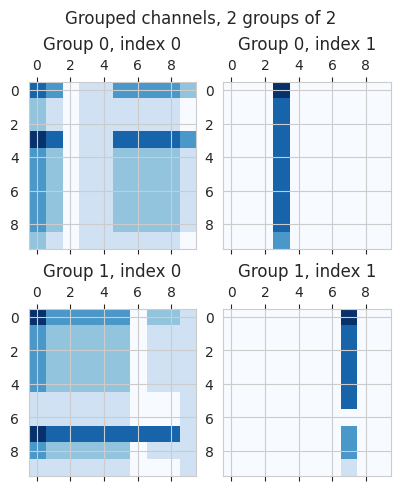

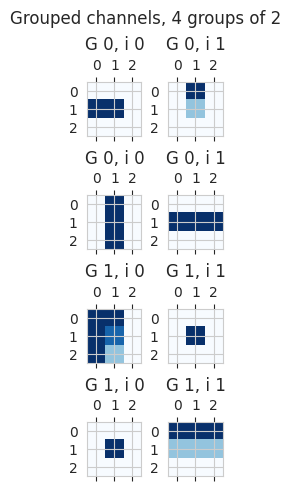

In [15]:
def plot_gradients(
    op, data: torch.Tensor, kernel: torch.Tensor, groups: int, **conv_kwargs
):
    data = data.clone().requires_grad_(True)
    kernel = kernel.clone().requires_grad_(True)
    res: torch.Tensor = op(data, kernel, groups=groups, **conv_kwargs)
    res.sum().backward()
    plot_grouped_data(data.grad, groups, vmin=0, vmax=5)
    plot_grouped_data(
        kernel.grad.flatten(end_dim=1), groups=groups, is_kernel=True, vmin=0, vmax=5
    )


plot_gradients(ss_op, test_data, test_kernels, groups=2, padding=1)

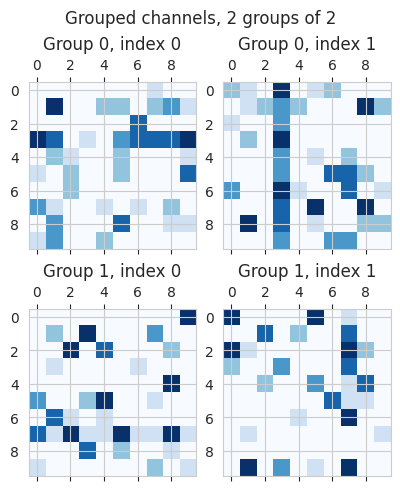

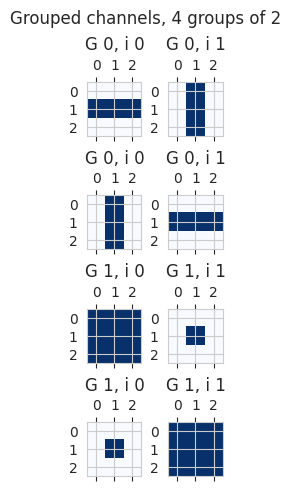

In [16]:
# With a tiny bit of noise, to prevent max from always picking the first
torch.manual_seed(0)
plot_gradients(
    ss_op,
    test_data + torch.randn_like(test_data) * 1e-5,
    test_kernels,
    groups=2,
    padding=1,
)

In [17]:
# Broadcast testing
ss_op_bc = convolutions.SelectSemifield.tropical_max().module()
ss_op_bc

SelectConv()

Inferred meta=ConvMeta(img_bs=2, img_cs=4, img_ys=10, img_xs=10, krn_o_group_size=1, krn_os=1, krn_cs=2, krn_ys=3, krn_xs=3, out_cs=2, out_ys=10, out_xs=10, stride=1, padding=1, dilation=1, groups=2, group_broadcasting=True)
torch.Size([2, 2, 10, 10])


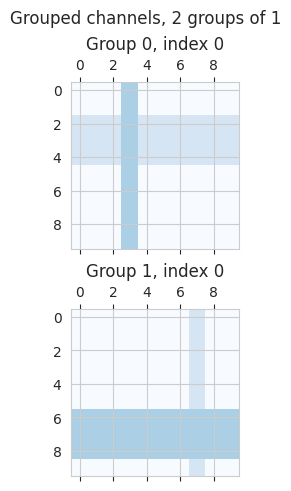

In [18]:
res_bc = ss_op_bc(
    test_data,
    test_kernels[2:3],
    groups=2,
    debug=True,
    padding=1,
    group_broadcasting=True,
)
print(res_bc.shape)
plot_grouped_data(res_bc, groups=2)

In [19]:
import importlib
from src import convolutions
from src.convolutions import cuda_select, unfold_broadcast, utils

importlib.reload(utils)
importlib.reload(cuda_select)
importlib.reload(convolutions)
importlib.reload(unfold_broadcast)
from src import convolutions

In [20]:
un_max = convolutions.BroadcastSemifield.tropical_max().module()
un_max

BroadcastConv()

torch.Size([2, 4, 10, 10]) tensor(0., device='cuda:0') tensor(6., device='cuda:0')


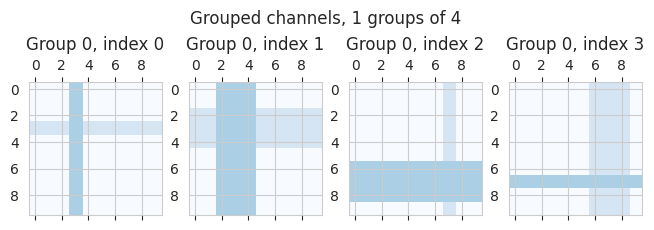

In [21]:
res_un = un_max(test_data, test_kernels, groups=2, padding=1)
print(res_un.shape, res_un.min(), res_un.max())
plot_grouped_data(res_un, 1)

In [22]:
torch.isclose(res_un, res_ss).all()

tensor(True, device='cuda:0')

In [23]:
# Now, without groups (single channels)
single_ss = convolutions.SelectSemifield.tropical_max().module()
single_trop = convolutions.TropicalConv2D(is_max=True)
single_un = convolutions.BroadcastSemifield.tropical_max().module()

In [24]:
rsingle_ss = single_ss(test_data, test_kernels[:, :1], padding=1, groups=4)
rsingle_trop = single_trop(test_data, test_kernels[:, :1], padding=1, groups=4)
rsingle_un = single_un(test_data, test_kernels[:, :1], padding=1, groups=4)

In [25]:
print(torch.isclose(rsingle_ss, rsingle_trop).all())
print(torch.isclose(rsingle_un, rsingle_trop).all())
print(torch.isclose(rsingle_ss, rsingle_un).all())

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
